## Residential Energy Consumption Survey (RECS)

### Nov 2019 Applied Data Science Meetup
### Portland Data Science Group
#### John Burt


#### Purpose of this notebook:

Explore the feature columns: 

- SCALEB, Frequency of reducing or forgoing basic necessities due to home energy bill
- SCALEG, Frequency of keeping home at unhealthy temperature
- SCALEE, Frequency of receiving disconnect notice

These variables indicate the level of hardship a customer is experiencing. My goal is to combine them into one score that can be used a target variable for our predictive model. I will use PCA, but first I need to varifiy that the variables are correlated.

In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

srcdir = './data/'

# load the data
df = pd.read_csv(srcdir+'recs2015_public_v4.csv') 


In [3]:
df.head()

,DOEID,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,ZBASEFIN,ATTIC,ZATTIC,ATTICFIN,ZATTICFIN,STORIES,ZSTORIES,PRKGPLC1,ZPRKGPLC1,SIZEOFGARAGE,ZSIZEOFGARAGE,KOWNRENT,ZKOWNRENT,YEARMADERANGE,ZYEARMADERANGE,OCCUPYYRANGE,ZOCCUPYYRANGE,STUDIO,ZSTUDIO,BEDROOMS,ZBEDROOMS,NCOMBATH,ZNCOMBATH,NHAFBATH,ZNHAFBATH,OTHROOMS,ZOTHROOMS,TOTROOMS,ZTOTROOMS,WALLTYPE,ZWALLTYPE,ROOFTYPE,ZROOFTYPE,HIGHCEIL,ZHIGHCEIL,DOOR1SUM,ZDOOR1SUM,WINDOWS,ZWINDOWS,TYPEGLASS,...,DOLLPWTH,DOLLPCOK,DOLLPCDR,DOLLPNEC,GALLONFO,GALLONFOSPH,GALLONFOWTH,GALLONFONEC,BTUFO,BTUFOSPH,BTUFOWTH,BTUFONEC,DOLLARFO,DOLFOSPH,DOLFOWTH,DOLFONEC,TOTALBTU,TOTALDOL,TOTALBTUSPH,TOTALDOLSPH,TOTALBTUWTH,TOTALDOLWTH,TOTALBTUCOK,TOTALDOLCOK,TOTALBTUCDR,TOTALDOLCDR,TOTALBTUPL,TOTALDOLPL,TOTALBTUHTB,TOTALDOLHTB,TOTALBTUNEC,TOTALDOLNEC,WOODAMT,ZWOODAMT,WOODBTU,PELLETAMT,ZPELLETAMT,PELLETBTU,ELXBTU,PERIODEL,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
0,10001,4,10,METRO,U,2,0,0,0,-2,-2,0,0,-2,-2,20,0,1,0,2,0,1,0,7,0,8,0,-2,-2,3,0,2,0,1,0,4,0,7,0,4,0,1,0,1,0,2,0,41,0,2,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48974.570,1406.10,12469.727,176.59,17535.625,248.33,985.448,13.96,1727.078,92.89,0.0,0.0,0.0,0.0,1749.457,94.09,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
1,10002,3,7,NONE,R,2,0,0,0,-2,-2,0,0,-2,-2,10,0,0,0,-2,-2,1,0,5,0,6,0,-2,-2,2,0,1,0,0,0,2,0,4,0,3,0,3,0,0,0,0,0,20,0,1,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41534.000,1366.00,11570.020,380.52,7129.985,234.49,1006.820,33.11,0.000,0.00,0.0,0.0,0.0,0.0,3188.852,104.88,-2.0,-2,0.0,-2.0,-2,0.0,3.412,5,1,NaN,-2,-2,137.45,-2,-2,91.33,-2,-2
2,10003,3,6,METRO,U,2,0,1,0,1,0,0,0,-2,-2,10,0,0,0,-2,-2,1,0,4,0,7,0,-2,-2,4,0,2,0,0,0,5,0,9,0,2,0,5,0,0,0,1,0,41,0,1,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96548.160,2828.84,23499.517,601.17,18444.442,250.71,4650.068,168.36,1819.709,65.88,0.0,0.0,0.0,0.0,3553.130,128.64,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2
3,10004,2,4,MICRO,C,2,0,1,0,1,0,0,0,-2,-2,10,0,1,0,2,0,1,0,2,0,7,0,-2,-2,3,0,2,0,0,0,4,0,7,0,3,0,5,0,1,0,4,0,42,0,2,...,114.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89284.345,2102.98,52408.189,863.46,8077.839,114.62,384.600,15.02,1702.112,66.49,0.0,0.0,0.0,0.0,1905.175,74.42,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,NaN,-2,-2,137.45,-2,-2,91.33,2,0
4,10005,1,2,METRO,U,2,0,1,0,0,0,1,0,0,0,20,0,1,0,1,0,1,0,4,0,8,0,-2,-2,3,0,2,0,0,0,3,0,6,0,1,0,5,0,0,0,1,0,30,0,1,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36582.146,910.89,5339.841,67.87,17331.011,220.26,2265.816,28.80,1002.376,54.79,0.0,0.0,0.0,0.0,3586.574,153.47,-2.0,-2,0.0,-2.0,-2,0.0,3.412,1,0,102.83,1,0,137.45,-2,-2,91.33,-2,-2


### Remap column values

I'm going to swap the coding values so that the numbers describe a range, from 0 (no months per year) to 3 (every month per year). 

Currently:
- 1 = Almost every month 
- 2 = Some months
- 3 = 1 or 2 months
- 0 = Never

Change to:
- 0 = Never
- 1 = 1 or 2 months
- 2 = Some months
- 3 = Almost every month 


In [23]:
# transform mapping
xform = {0:0, 1:3, 2:2, 3:1}

# remap the variables
df['SCALEBf'] = df['SCALEB'].map(xform)
df['SCALEGf'] = df['SCALEG'].map(xform)
df['SCALEEf'] = df['SCALEE'].map(xform)


### Histograms and correlations

All of the variables are significantly positively correlated. 

The histograms indicate that most samples are 0 (no economic distress).

Spearman rank correlations:

SCALEBf vs SCALEGf: coef=0.415, pval=0.00000
SCALEBf vs SCALEEf: coef=0.439, pval=0.00000
SCALEGf vs SCALEEf: coef=0.225, pval=0.00000

Histograms:


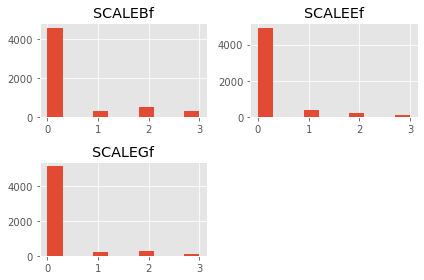

In [46]:
from scipy.stats import spearmanr

def print_corr(df, var1, var2):
    """Calc Spearman corr and print result"""
    coef, pval = spearmanr(df[var1],df[var2])
    print('%s vs %s: coef=%1.3f, pval=%1.5f'%(var1,var2,coef,pval))

print('Spearman rank correlations:\n')
print_corr(df,'SCALEBf','SCALEGf')
print_corr(df,'SCALEBf','SCALEEf')
print_corr(df,'SCALEGf','SCALEEf')

print('\nHistograms:')

df[['SCALEBf','SCALEGf','SCALEEf']].hist();
plt.tight_layout();


### Generate a PCA "hardship score"

Significan correlations between all vars indicates I can combine them to make a single score using PCA.

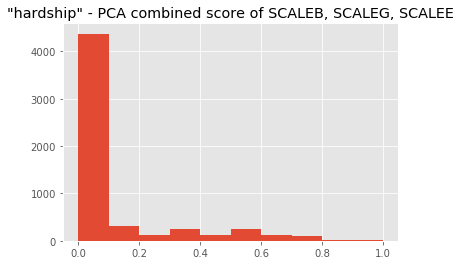

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# create PCA object
pca = PCA(n_components=1)

# do the PCA and save combined score to new 'hardship' column
df['hardship'] = pca.fit_transform(df[['SCALEBf','SCALEGf','SCALEEf']])

# scale the hardship values between 0 - 1
df['hardship'] = MinMaxScaler().fit_transform(
    df['hardship'].values.reshape(-1, 1))

# plot histo of new hardship score
df['hardship'].hist();
plt.title('"hardship" - PCA combined score of SCALEB, SCALEG, SCALEE');